In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import data_preprocessing as dp
import utilities
import models.training as train
from models.classifiers import ConvNet1
from models.autoencoder import ConvolutionalAutoencoder

Creating RawArray with float64 data, n_channels=128, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


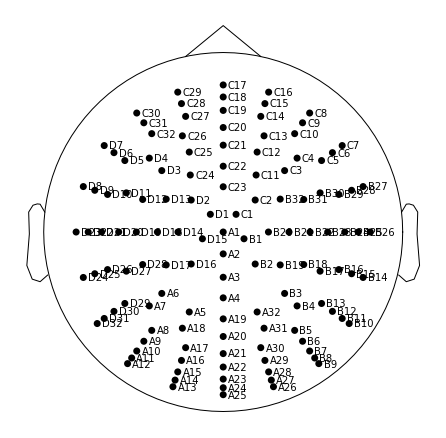

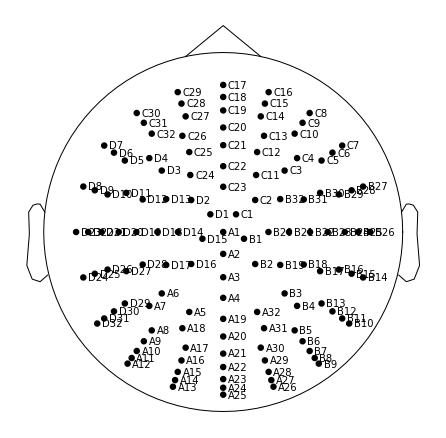

In [2]:
Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
montage.plot()

# https://www.frontiersin.org/articles/10.3389/fneur.2020.00375/full

## Dataset
Data is epoched, keeping only the 4.5s length signals correpsonding to the time window between the beginning of the concentration interval and the end of the relacation interval.


In [3]:
data, events = dp.load_data(subjects=range(1,4))

In [4]:
import numpy as np
data, events = dp.choose_condition(data, events, 'inner speech')
data = data.astype(np.float16) * 100_000  # NORMALIZATION ONLY POSSIBLE BY MULTIPLYING HERE?

In [5]:
data = dp.normalization(data)

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((data, events[:, 1]))
dataset = dp.preprocessing_pipeline(
    dataset,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                 dp.filter_interval], # filter out a certain interval
    args = [[], [[1, 3.5], 256]],
    batch_size = 12
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-25 14:47:29.689974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-25 14:47:29.690093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# split dataset into train, validation and test subsets
datasets = dp.split_dataset(dataset)

2022-02-25 14:47:29.986734: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Display Data

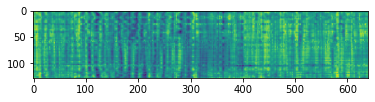

In [8]:
for data_batch, target_batch in datasets['test'].take(1):
    utilities.plot_eeg_data(data_batch[0])

### Model-Testing

In [9]:
# MOVE THIS TO PREPROCESSING
for key, value in datasets.items():
    datasets[key] = value.map(lambda i, t: (tf.reshape(i, (12, 128, 640, 1)), t))


In [10]:
# Model
net1 = ConvNet1()
# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()
# train
#losses_res, accuracies_res = train.training(net1, datasets, cross_entropy_loss,
#                                            optimizer, epochs=5)

### Autoencoder

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           multiple                  160       
                                                                 
 conv2d_4 (Conv2D)           multiple                  1160      
                                                                 
 conv2d_5 (Conv2D)           multiple                  584       
                                                                 
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  multiple                 584       
 nspose)                                                         
                                        

2022-02-25 14:47:30.673904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


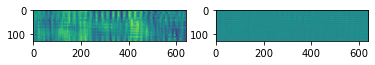

In [11]:
autoencoder = ConvolutionalAutoencoder()
autoencoder.build((None, 128,640,1))
autoencoder.encoder.summary()
autoencoder.decoder.summary()

for i, t in datasets['train'].take(1):
    out = autoencoder(i)
    plt.subplot(1,2,1)
    plt.imshow(i[0][:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(out[0][:,:,0])

In [12]:
%matplotlib tk
#model = ConvolutionalAutoencoder()
# Initialize the loss-function
loss_func = tf.keras.losses.MeanSquaredError() #CategoricalCrossentropy()
# Initialize the optimizer
#optimizer = tf.keras.optimizers.SGD(0.1)
optimizer = tf.keras.optimizers.Adam()
autoencoder_dataset = tf.data.Dataset.from_tensor_slices((data, data))
autoencoder_dataset = dp.preprocessing_pipeline(
    autoencoder_dataset,
    functions = [dp.filter_interval,
                 lambda sample: (tf.reshape(sample[0], (128, 640, 1)),
                                 tf.reshape(sample[0], (128, 640, 1)))
                ],
    args = [[[1, 3.5], 256, [0, 1]], []],
    batch_size = 12
)
autoencoder_datasets = dp.split_dataset(autoencoder_dataset)

# Train
losses, accuracies = train.training(autoencoder, autoencoder_datasets, loss_func, optimizer, 'mse', epochs=100)

2022-02-25 14:47:34.356592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-25 14:47:35.917841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-25 14:47:35.967761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
for i, t in datasets['valid'].take(1):
    out = model(i)
    plt.subplot(1,2,1)
    plt.imshow(i[0][:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(out[0][:,:,0])

NameError: name 'datasets' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


class TrainingGrapher:
    def __init__(self, *args, name=None, supxlabel=None, supylabel=None, axs_xlabels=None, axs_ylabels=None, x_scale=None, y_scale=None):
        self.x_scale = x_scale
        self.y_scale = y_scale
        self.plot_shape = args

        plt.ion()
        self.fig, self.axs = plt.subplots(*args)
        # put self.axs in brackets so that its rank becomes 2
        for i in range(2 - (len(self.axs.shape) if type(self.axs) is np.ndarray else 0)):
            self.axs = np.array([self.axs])
        self.lines = [self.axs[y, x].plot([])[0] for y, x in np.ndindex(self.axs.shape)]
        # figure settings
        if name: self.fig.suptitle(name, size='x-large', weight='semibold')
        if supxlabel: self.fig.supxlabel(supxlabel)
        if supylabel: self.fig.supylabel(supylabel)
        # axis settings
        for y, x in np.ndindex(self.axs.shape):
            # set scales
            if x_scale:
                xlim = x_scale if type(x_scale[0]) is int else x_scale[y][x]
                if xlim:
                    self.axs[y, x].set_xlim(xlim)
            if y_scale:
                ylim = y_scale if type(y_scale[0]) is int else y_scale[y][x]
                if ylim: self.axs[y, x].set_ylim(ylim)
            # set labels
            if axs_xlabels:
                self.axs[y, x].set_xlabel(axs_xlabels[y][x])
            if axs_ylabels:
                self.axs[y, x].set_ylabel(axs_ylabels[y, x])
    
    
    def axs_setting(ylabel, xlabel):
        pass
    
    def update(self, xdata, ydata):
        for i, (line, xd, yd) in enumerate(zip(self.lines, xdata, ydata), 1):
            line.set_data(xd, yd)
            # autoscaling if necesarry
            if not self.x_scale or (self.x_scale[i%self.plot_shape[1]][i//self.plot_shape[0]] is None):
                print(min(yd), max(yd))
                self.axs[i%self.plot_shape[1], i//self.plot_shape[0]].set_xlim(min(xd), max(xd))
            if not self.y_scale or (self.y_scale[i%self.plot_shape[1]][i//self.plot_shape[0]] is None):
                self.axs[i%self.plot_shape[1], i//self.plot_shape[0]].set_ylim(min(yd), max(yd))

        plt.show()
        plt.pause(0.3)
        

In [ ]:
%matplotlib tk
graph = TrainingGrapher(2, 1, name="Training Progress", supxlabel='Epochs', axs_xlabels=[["A", "B"]], x_scale=[[None, [0, 20]]], y_scale=[[None, [0,1]]])
for j in range(1, 42):
    graph.update([np.array(range(j+1)) for i in range(4)], [np.random.rand(j+1) for _ in range(4)])

#graph.fig.savefig('t')

0.24955961965679108 0.8693167552751895
0.1654150887671294 0.7723243164897176
0.19184650348900445 0.7944266593959302
0.11538814012270981 0.7044803468018223
0.14162549747072029 0.9686845142227496
0.19736965224856606 0.9727870065218165
0.258770411910482 0.8423288715747649
0.23095986986894557 0.9519411817578626
0.06180365277916344 0.9186441206531631
0.07421377273240315 0.9477528062191483
0.05643919102475581 0.9941941056001788
0.18525800473360443 0.9735413619029911
0.04893710543521412 0.9322551069999109
0.009721826360358232 0.9479854427705108
0.01618250022412404 0.9604758204259438
0.011890363791059788 0.9990792779735637
0.015032845203807543 0.9477405991942394
0.018819076940393198 0.9192331621447072
0.09873458767185883 0.9984514070108162
0.031774485405503206 0.9991887760003685
0.01996613955398774 0.9632970266930381
0.2317193640265891 0.9770754424277502
0.05203559777329658 0.946367557245147
0.011627388664352978 0.9589447443032727
0.0029739300620870157 0.9439185352476506
0.0684003884727642 0.9